# Домашнее задание 3. VAE + NF + VAPNEV

### Загрузка данных
В данном задании вам предстоит снова работать с CelebA, но уже 64x64

Решением домашки является архив с использованными тетрадками/модулями, а так же .pdf файл с отчетом по проделанной работе по каждому пункту задачи. В нем необходимо описать какие эксперименты вы производили чтобы получить результат который вы получили, а так же обосновать почему вы решили использовать штуки которые вы использовали (например, дополнительные лоссы для стабилизации, разные виды потоков, разные хаки для вае)



In [1]:
!git clone https://github.com/HSE-LAMBDA/DeepGenerativeModels.git
%cd DeepGenerativeModels/

In [2]:
#!g1.1
from celeba import CelebADataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import math
from tqdm.auto import trange, tqdm
import os 
from torch import nn
from glow import Glow
from train_utils import train_loop
from vae import Vae64x64
from torch.utils.data import DataLoader
from torchvision import utils
from torchmetrics.image import FrechetInceptionDistance
from tqdm.auto import tqdm, trange
from torch import Tensor

In [3]:
#!g1.1
t_normalize = lambda x: x * 2 - 1
t_invnormalize = lambda x: (x + 1) / 2
transform=transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    t_normalize,
])

In [4]:
#!g1.1
from random import randint

class CelebaCustomDataset(CelebADataset):
    def __getitem__(self, idx):
        image, target = super().__getitem__(idx)
        return image

dataset = CelebaCustomDataset(
    transform=transform,
    attr_file_path='list_attr_celeba.txt',
    crop=False
)

img = dataset[0]

### Визуализация датасета

In [6]:
#!g1.1
def plot_img(img, transform):
    plt.imshow(transform(img).permute(1, 2, 0))
    plt.axis('off')

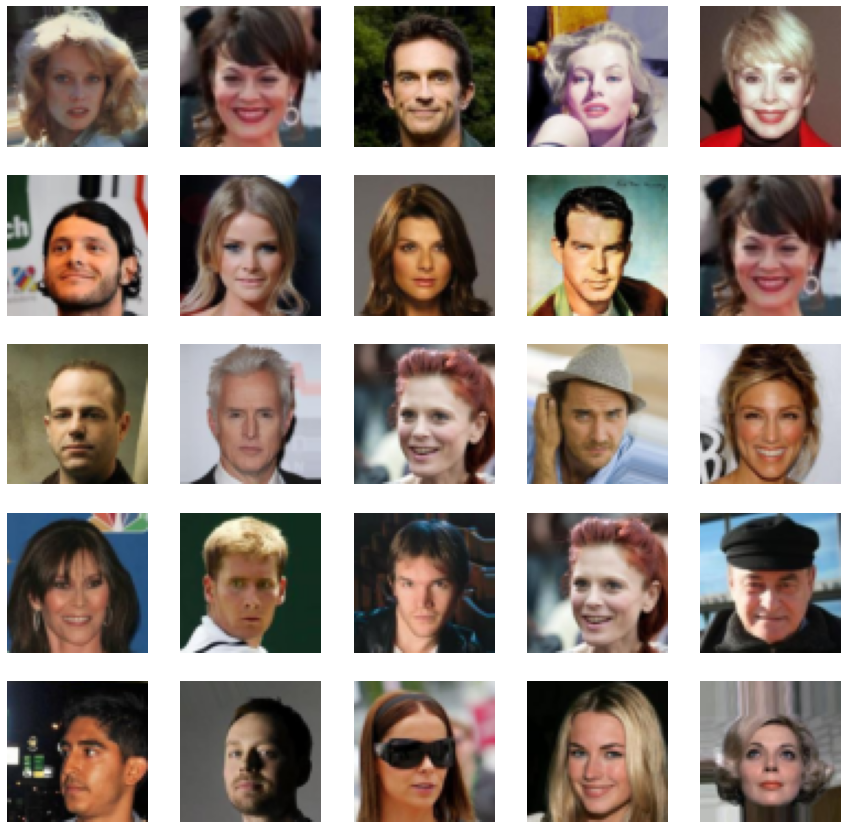

In [7]:
#!g1.1
plt.figure(figsize=(15, 15))

for i in range(25):
    img = dataset[np.random.randint(len(dataset))]
    plt.subplot(5, 5, i + 1)
    plot_img(img, t_invnormalize)
plt.show()

### Задача 1 (4/10 балла). Построить и обучить нормпоток на CelebA

Здесь нужно обучить нормпоток до нормального (трешхолды будут позже) качества, померить FID и Negative Log Likelihood и запомнить для будущего сравнения

Внутри потока можно использовать все что вы хотите, Coupling/Autoregressive/Linear слои, любые трансформации и все что вам приходит в голову. Но все что вы используете - напишите сами, без копипаста.

Можно использовать как и сверточные потоки (будут лучше, но сложнее писать), так и линейные (будут хуже), развернув селебу в один вектор.

В принципе можно использовать тот код который уже есть в репозитории курса, но лучше написать свой

In [8]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [9]:
def calc_size(net):
    param_size = 0
    for param in net.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in net.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    gen_size = (param_size + buffer_size) / 1024**2
    return gen_size


def measure_fid(model, real_dataset, batch_size, noise_func):
    assert len(real_dataset) % batch_size == 0
    with catch_warnings():
        simplefilter("ignore")
        fid = FrechetInceptionDistance(feature=64)

    for real_images in tqdm(DataLoader(real_dataset, batch_size=batch_size), desc="Real images"):
        real_images = (real_images * 255).byte()
        fid.update(real_images, real=True)

    model.eval()
    for _ in trange(len(real_dataset) // batch_size, desc="Fake images"):
        fake_batch = noise_func(batch_size)
        with torch.no_grad():
            fake_images = model.sample(fake_batch).detach().cpu()
        fake_images = (fake_images * 255).byte()
        fid.update(fake_images, real=False)

    return fid.compute().item()

In [10]:
N_BITS = 5
N_BINS = 2**N_BITS
SAMPLE_TEMP = 0.6


def glow_loss(log_p, log_det, image_size):
    n_pixel = image_size * image_size * 3

    loss = -log(N_BINS) * n_pixel
    loss += log_det + log_p

    return (-loss / (log(2) * n_pixel)).mean()


def quantize_preprocess(images):
    images = images * 255  # undo ToTensor scaling to [0,1]
    if N_BITS < 8:
        images = torch.floor(images / 2 ** (8 - N_BITS))
    images = images / N_BINS - 0.5
    return images


def glow_train_step(glow_model, images):
    images = quantize_preprocess(images)
    noise = torch.zeros_like(images).uniform_(0, 1.0 / N_BINS)
    log_p, log_det, _ = glow_model(images + noise)
    log_det = log_det.mean()
    loss = glow_loss(log_p, log_det, images.shape[-1])
    return loss

In [30]:
glow_celeba = Glow(k_flow=22, l_block=4, n_filters=512).to(device)

glow_celeba_dataloader = DataLoader(dataset, batch_size=16, shuffle=True, drop_last=True)

z_shapes = glow_celeba.get_sample_noise_shapes(dataset[0].shape[-1])
z_noise = [torch.randn(49, *z, device=device) * SAMPLE_TEMP for z in z_shapes]

print(f"model size: {calc_size(glow_celeba):.3f} MB")

model size: 196.602 MB


In [12]:
glow_ckpt_url = "https://drive.google.com/file/d/1qjJ62W0ddm6pmGVj4NLAKsq-AGAO6eGa/view?usp=sharing"
gdown.download(glow_ckpt_url, "glow.ckpt", quiet=True, fuzzy=True)

'glow.ckpt'

In [31]:
state_dict = torch.load("glow.ckpt", map_location=device)
glow_celeba.load_state_dict(state_dict)
glow_celeba.sef_init_false()

In [ ]:
glow_losses = train_loop(
    glow_celeba, glow_celeba_dataloader, z_noise, glow_train_step, device, n_epochs=1, lr=0.0001, decay_gamma=0.8
)

In [14]:
fid = measure_fid(
    glow_celeba, dataset, 100, lambda bs: [torch.randn(bs, *z, device=device) * SAMPLE_TEMP for z in z_shapes]
)
print(f"GLOW FID score on croped CelebA 64x64: {round(fid, 3)}")

Real images:   0%|          | 0/5 [00:00<?, ?it/s]

Fake images:   0%|          | 0/5 [00:00<?, ?it/s]

GLOW FID score on croped CelebA 64x64: 0.89


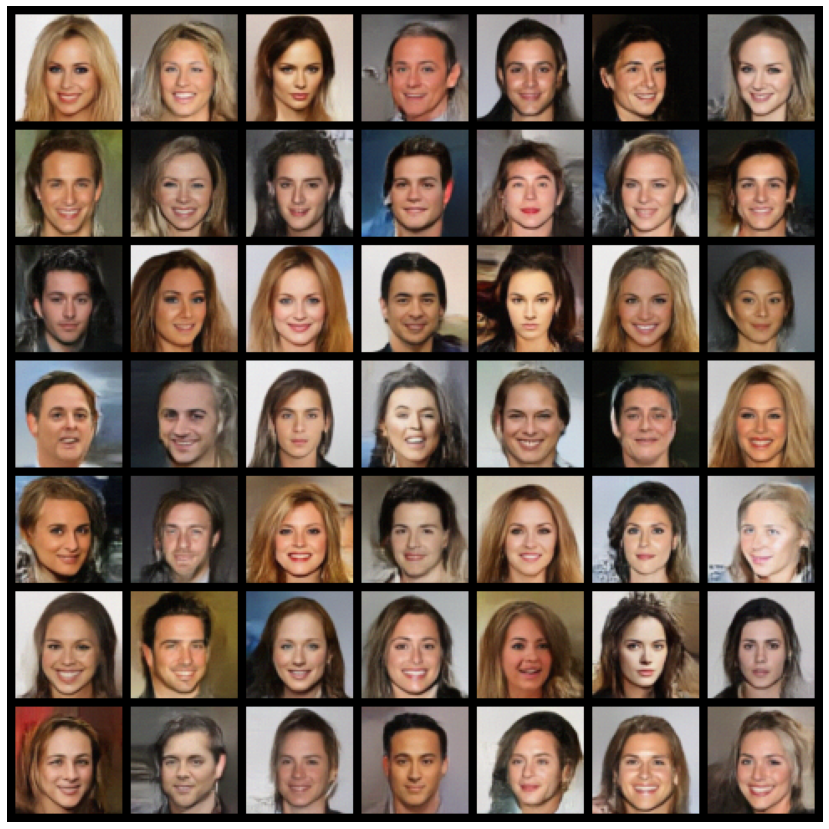

In [33]:
glow_celeba.eval()
with torch.no_grad():
    img = glow_celeba.sample(z_noise).detach().cpu()

plt.figure(figsize=(15, 15))
grid = utils.make_grid(img, nrow=7, padding=5)
plot_img(grid)
plt.savefig(join("glow", f"random_samples_temp_{SAMPLE_TEMP}.png"), bbox_inches="tight")

### Задача 2 (2/10 балла). Построить и обучить VAE на CelebA

Здесь нужно обучить VAE до нормального качества, померить FID и запомнить для будущего сравнения. 

В принципе можно использовать тот код который уже есть в репозитории курса, но лучше написать свой

Ради интереса, ваше вае тоже можно потестировать на маленьких датасетах


In [16]:
KLD_LAMBDA = 0.00025


def vae_loss(x, reconstruct, mu, log_sigma):
    reconstruction_loss = F.mse_loss(x, reconstruct)

    kld_loss = (0.5 * (torch.exp(2 * log_sigma) + mu**2 - 2 * log_sigma - 1)).sum(dim=1).mean()

    loss = reconstruction_loss + KLD_LAMBDA * kld_loss
    return loss


def vae_train_step(vae_model, images):
    images = 2 * images - 1
    reconstruct, z, mu, log_sigma = vae_model(images)
    loss = vae_loss(images, reconstruct, mu, log_sigma)
    return loss

In [34]:
vae_celeba = Vae64x64(latent_dim=128).to(device)

vae_celeba_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
z_noise = torch.randn(49, vae_celeba.latent_dim, device=device)

print(f"model size: {calc_size(vae_celeba):.3f} MB")

model size: 15.032 MB


In [18]:
vae_ckpt_url = "https://drive.google.com/file/d/1U2yTLE5KqnVayozxOWs1BffuP__R_WVA/view?usp=sharing"
gdown.download(vae_ckpt_url, "vae.ckpt", quiet=True, fuzzy=True)

'vae.ckpt'

In [35]:
state_dict = torch.load("vae.ckpt", map_location=device)
vae_celeba.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
vae_losses = train_loop(
    vae_celeba, vae_celeba_dataloader, z_noise, vae_train_step, device, n_epochs=20, lr=0.005, decay_gamma=0.95
)

In [20]:
fid = measure_fid(vae_celeba, dataset, 100, lambda bs: torch.randn(bs, vae_celeba.latent_dim, device=device))
print(f"VAE FID score on croped CelebA 64x64: {round(fid, 3)}")

Real images:   0%|          | 0/5 [00:00<?, ?it/s]

Fake images:   0%|          | 0/5 [00:00<?, ?it/s]

VAE FID score on croped CelebA 64x64: 1.655


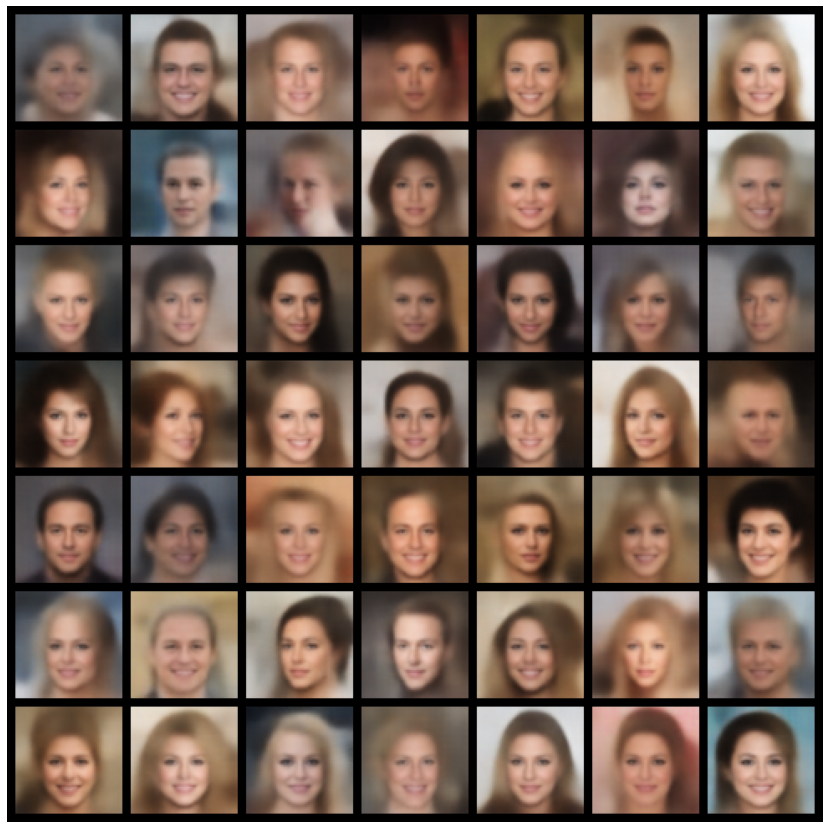

In [36]:
vae_celeba.eval()
with torch.no_grad():
    img = vae_celeba.sample(z_noise).detach().cpu()

plt.figure(figsize=(15, 15))
grid = utils.make_grid(img, nrow=7, padding=5)
plot_img(grid)
plt.savefig(join("vae", "random_samples.png"), bbox_inches="tight")

### Задача 3 (6/10 балла). 

#### Задача 3.1 (4/10 балла) Построить и обучить VAPNEV на CelebA

Здесь нужно прочитать [статью про VAPNEV](https://arxiv.org/pdf/1611.05209.pdf), обучить его до нормального (трешхолды будут позже) качества, померить FID и запомнить для будущего сравнения. 

#### Задача 3.2 (2/10 балла). Построить и обучить conditional VAPNEV на CelebA

Вроде понятно из текста задачи. Что такое conditional VAPNEV, читайте в статье

In [ ]:
# YOUR CODE HERE

### Задача 4. (1/10 балла) Анализ

* Анализ латентного пространства и визуально качественный результат - **1 балл**
1. Посмотрите у какой модели получается лучшая интерполяция в латентном пространстве
2. Попробуйте взять внешнюю картинку (не из селебы), отмапить ее с латентное пространство и покажите ближайшие к ней.
3. Покажите самый смешной результат генерации который у вас получался

In [46]:
interpolation_images = [dataset[np.random.randint(len(dataset))] for _ in range(10)]
b_interpolation_images = torch.stack(interpolation_images)

torch.Size([3, 64, 64])


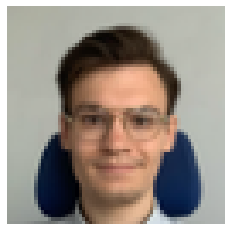

In [23]:
non_celeba_img_path = "non_celeba.png"
non_celeba_img = plt.imread(non_celeba_img_path)

for t in [transforms.ToTensor(), transforms.Resize(64)]:
    non_celeba_img = t(non_celeba_img)

print(non_celeba_img.shape)
plot_img(non_celeba_img)

## Анализ GLOW

### Temperature effect

Высокая температура при семплировании шума может привести к зашумлённым изображениям, которые далеки от реального распределения. С другой стороны низкая температура приведёт к однообразной генерации. Как и в оригинальной работе, оценим качество картинок при разных температурах (от 0 до 1).

**Вывод**: температура 0.6 выглядит отличным балансом между разнообразием и качеством.

  0%|          | 0/6 [00:00<?, ?it/s]

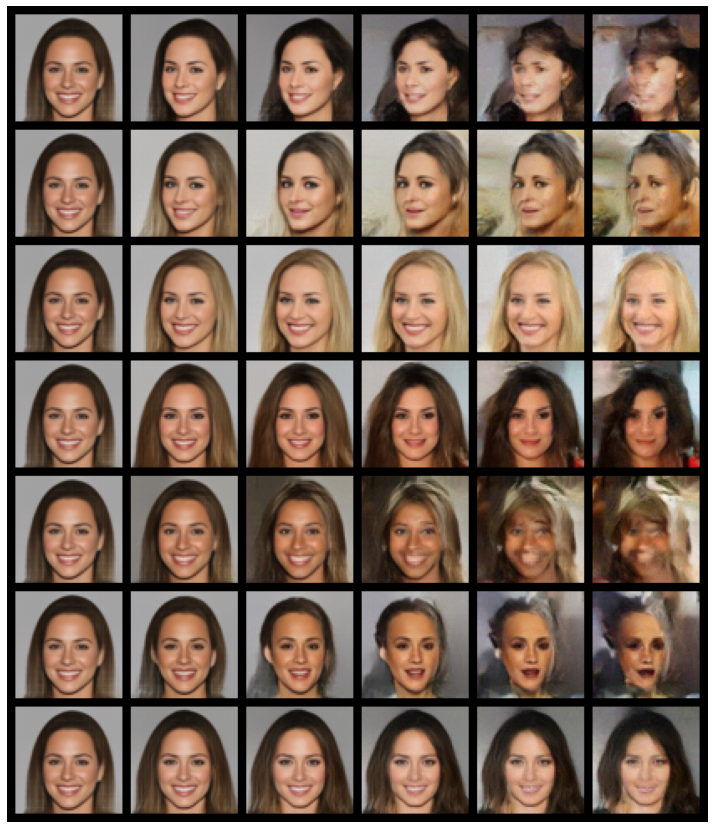

In [38]:
glow_celeba.eval()
z_temp_noise = [torch.randn(7, *z, device=device) for z in z_shapes]

images = []
for t in tqdm([0, 0.2, 0.4, 0.6, 0.8, 1]):
    cur_noise = [z * t for z in z_temp_noise]
    with torch.no_grad():
        img = glow_celeba.sample(cur_noise).detach().cpu()
    images.extend(img)

transpose_images = [images[t * 7 + i] for i in range(7) for t in range(6)]

plt.figure(figsize=(15, 15))
grid = utils.make_grid(transpose_images, nrow=6, padding=5)
plot_img(grid)
plt.savefig(join("glow", f"temperature_effect.png"), bbox_inches="tight")

### Интерполяция

**Вывод**: GLOW хорошо интерполирует между двумя картинками, особенно при одинаковом положении лиц на крайних изображениях. Когда на двух фотографиях лица смотрят под разным углом или вообще в разные стороны, то в середине проглядываются артефакты.

  0%|          | 0/5 [00:00<?, ?it/s]

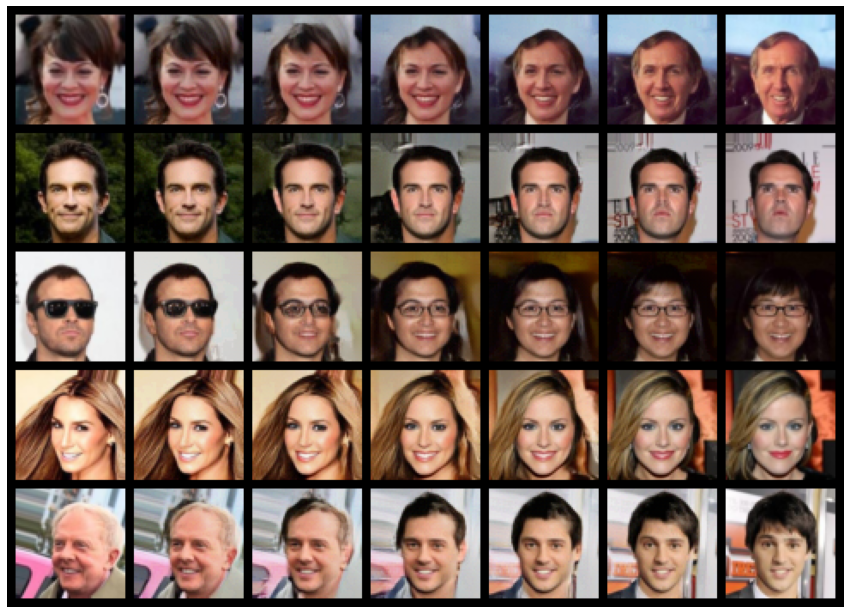

In [47]:
glow_celeba.eval()
with torch.no_grad():
    batch = quantize_preprocess(b_interpolation_images)
    _, _, edge_z = glow_celeba(batch)

images = interpolation_images[:5]
for i in tqdm(range(1, 6)):
    with torch.no_grad():
        inter_z = [l[:5] + (l[5:] - l[:5]) * i / 6 for l in edge_z]
        img = glow_celeba.reverse(inter_z, is_reconstruct=True)
    images.extend(img.clamp(-0.5, 0.5) + 0.5)
images.extend(interpolation_images[5:])

transpose_images = [images[t * 5 + i] for i in range(5) for t in range(7)]

plt.figure(figsize=(15, 15))
grid = utils.make_grid(transpose_images, nrow=7, padding=5)
plot_img(grid)
plt.savefig(join("glow", f"interpolation.png"), bbox_inches="tight")

### Поиск ближайших
Так как скрытое состояние GLOW представляет собой множество `z`, то для поиска ближайших будем измерять расстояния на одинаковых уровнях, а затем усреднять по ним. 

  0%|          | 0/5 [00:00<?, ?it/s]

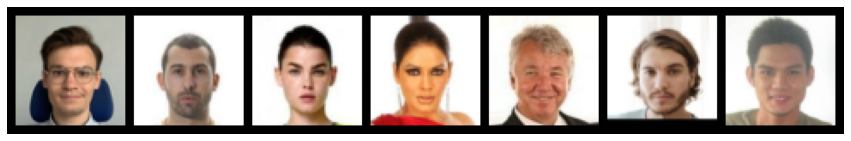

In [40]:
glow_latent_states_per_level = [[] for i in range(len(z_shapes))]

for b in tqdm(DataLoader(dataset, batch_size=100, shuffle=False, drop_last=False)):
    with torch.no_grad():
        _, _, z_out = glow_celeba(quantize_preprocess(b))
    for i in range(len(z_shapes)):
        glow_latent_states_per_level[i].append(z_out[i])

glow_latent_states_per_level = [torch.cat(it) for it in glow_latent_states_per_level]

with torch.no_grad():
    input_img = quantize_preprocess(non_celeba_img.unsqueeze(0))
    _, _, enc_img = glow_celeba(input_img)

distances = [
    torch.cdist(img.view(1, 1, -1), ls.view(500, 1, -1)).squeeze()
    for img, ls in zip(enc_img, glow_latent_states_per_level)
]
distances = torch.stack(distances).mean(0)
distances, idx = torch.sort(distances)

images = [non_celeba_img] + [dataset[i] for i in idx[:6]]
plt.figure(figsize=(15, 15))
grid = utils.make_grid(images, padding=5)
plot_img(grid)
plt.savefig(join("glow", f"find_closest.png"), bbox_inches="tight")

## Анализ VAE

### Reconstruction

**Вывод**: VAE хорошо восстанавливает положение лица, пол, цвет, эмоцию и т.п. Иногда есть трудности с возврастом. Волосы и окружение восстанавливаются плохо, проявляется известный blur от VAE.

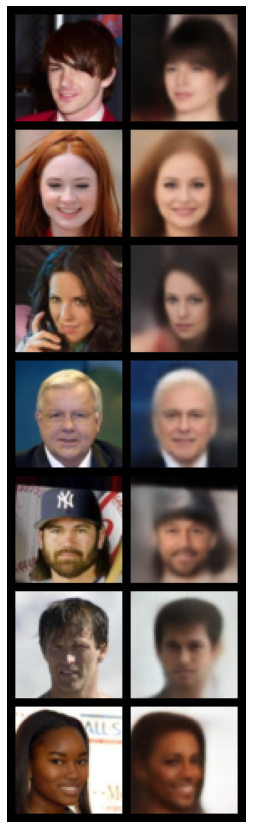

In [41]:
from_images = [dataset[np.random.randint(len(dataset))] for _ in range(7)]

vae_celeba.eval()
with torch.no_grad():
    batch = torch.stack(from_images) * 2 - 1
    _, z, _, _ = vae_celeba(batch)
    to_images = vae_celeba.sample(z)

images = [[from_images[i], to_images[i]] for i in range(7)]
images = sum(images, [])

plt.figure(figsize=(15, 15))
grid = utils.make_grid(images, nrow=2, padding=5)
plot_img(grid)
plt.savefig(join("vae", f"reconstruction.png"), bbox_inches="tight")

### Интерполяция

**Вывод**: VAE куда лучше справляется с разными положения лицами на краях интерполяции, но замыленность в целом не позволяет показать такое же высокое качество изображений в целом.

  0%|          | 0/7 [00:00<?, ?it/s]

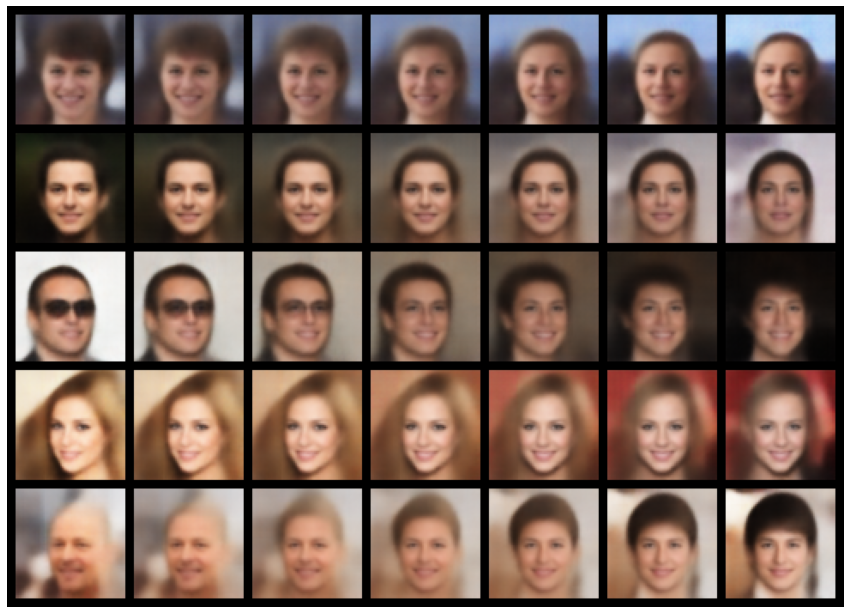

In [48]:
vae_celeba.eval()
with torch.no_grad():
    batch = b_interpolation_images * 2 - 1
    _, edge_z, _, _ = vae_celeba(batch)

images = []
for i in tqdm(range(0, 7)):
    with torch.no_grad():
        inter_z = edge_z[:5] + (edge_z[5:] - edge_z[:5]) * i / 6
        img = vae_celeba.sample(inter_z)
    images.extend(img)

transpose_images = [images[t * 5 + i] for i in range(5) for t in range(7)]

plt.figure(figsize=(15, 15))
grid = utils.make_grid(transpose_images, nrow=7, padding=5)
plot_img(grid)
plt.savefig(join("vae", f"interpolation.png"), bbox_inches="tight")

### Поиск ближайших

В качестве латентного представления будем использовать мат. ожидание кодируемых распределений ($\mu$).


  0%|          | 0/5 [00:00<?, ?it/s]

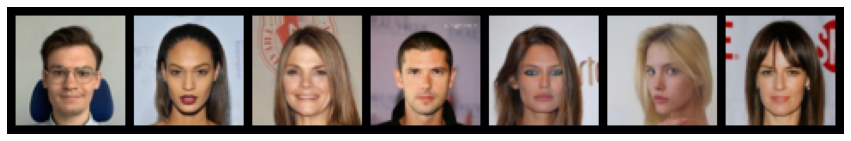

In [43]:
vae_latent_states = []

for b in tqdm(DataLoader(dataset, batch_size=100, shuffle=False, drop_last=False)):
    with torch.no_grad():
        b = b * 2 - 1
        mu, _ = vae_celeba.encode(b)
    vae_latent_states.append(mu)

vae_latent_states = torch.cat(vae_latent_states)

with torch.no_grad():
    enc_img, _ = vae_celeba.encode(non_celeba_img.unsqueeze(0) * 2 - 1)

distances = torch.cdist(enc_img.view(1, 1, -1), vae_latent_states.unsqueeze(0))
distances = distances.squeeze()
distances, idx = torch.sort(distances)

images = [non_celeba_img] + [dataset[i] for i in idx[:6]]

plt.figure(figsize=(15, 15))
grid = utils.make_grid(images, padding=5)
plot_img(grid)
plt.savefig(join("vae", f"find_closest.png"), bbox_inches="tight")

### Задача 0. Отчет

Чтобы получить полный балл за каждый из пунктов вам нужно включить в отчет (который сдатеся отдельно в виде pdf) примеры (лучше - много примеров) генерации вашей модели. 

Сравните результаты разных моделей, попробуйте обьяснить почему одна сработала лучше чем другая.